# KNeighborsClassifier

In [1]:
from __future__      import division
from IPython.display import display
from matplotlib      import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os

from sklearn.neighbors        import KNeighborsClassifier

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV

In [2]:
SEED   = 97
scale  = False 
minmax = False
norm   = False
nointercept = False
engineering = False

submission_filename = "../submissions/submission_KNeighborsClassifier.csv"

# Load the training data

In [3]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Fit the model

In [4]:
%%time

random.seed(SEED)


clf = KNeighborsClassifier(n_neighbors   = 5, 
                           weights       = 'distance',  # 'uniform', 'distance', a user-defined function 
                           algorithm     = 'auto', 
                           leaf_size     = 30, 
                           p             = 2, 
                           metric        = 'minkowski', # see DistanceMetric class
                           metric_params = None, 
                           n_jobs        = -1)



# StatifiedCV = StratifiedKFold(y            = y_train, 
#                               n_folds      = 10, 
#                               shuffle      = True, 
#                               random_state = SEED)

# param_grid = dict(n_neighbors     = [1, 5, 9, 17, 21, 27, 33, 41],
#                   weights  = ['uniform', 'distance'],
#                   metric   = ['minkowski','chebyshev','euclidean'])

# grid_clf = GridSearchCV(estimator  = clf, 
#                         param_grid = param_grid,
#                         n_jobs     = -1,  
#                         cv         = StatifiedCV,
#                         verbose    = 0
#                        )

# grid_clf.fit(X = X_train, y = y_train)

# print("clf_params = {}".format(grid_clf.best_params_))
# print("score: {}".format(round(grid_clf.best_score_, 4)))
# print

# clf = grid_clf.best_estimator_




clf_params = {'n_neighbors': 9, 'metric': 'chebyshev', 'weights': 'uniform'}
clf.set_params(**clf_params)
clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.11 ms


In [5]:
# from sklearn_utilities import GridSearchHeatmap

# GridSearchHeatmap(grid_clf, y_key='learning_rate', x_key='n_estimators')

# from sklearn_utilities import plot_validation_curves

# plot_validation_curves(grid_clf, param_grid, X_train, y_train, ylim = (0.0, 1.05))

/home/george/.local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


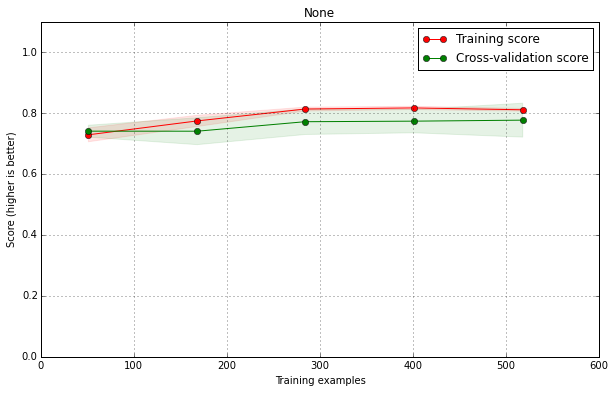

CPU times: user 872 ms, sys: 272 ms, total: 1.14 s
Wall time: 12.2 s


In [6]:
%%time

try:
    from sklearn_utilities import plot_learning_curve
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_learning_curve

plot_learning_curve(estimator   = clf, 
                    title       = None, 
                    X           = X_train, 
                    y           = y_train, 
                    ylim        = (0.0, 1.10), 
                    cv          = StratifiedKFold(y            = y_train, 
                                                  n_folds      = 10, 
                                                  shuffle      = True, 
                                                  random_state = SEED), 
                    train_sizes = np.linspace(.1, 1.0, 5),
                    n_jobs      = 1)

plt.show()

# Training set predictions

In [7]:
predicted_values = clf.predict(X_train)
y_true, y_pred   = y_train, predicted_values

predicted_probs  = clf.predict_proba(X_train)

[[418  20]
 [ 87  51]]


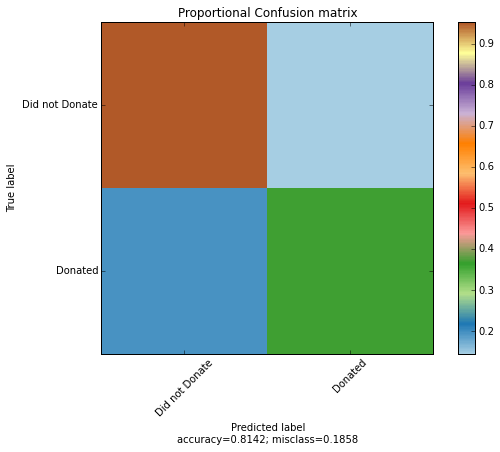

Accuracy 0.8142, mis-class rate 0.1858


In [8]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix


plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

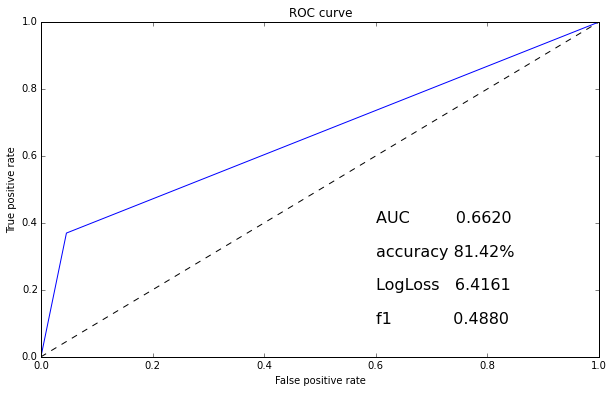

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(roc_auc_score(y_true, y_pred, average='macro')),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(log_loss(y_true, y_pred)),
        fontsize=16)

plt.text(x=0.6,y=0.1,s="f1            {:.4f}"\
         .format(f1_score(y_true, y_pred)),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Read the test data

In [41]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [42]:
y_pred        = clf.predict(X_test)
y_pred_probs  = clf.predict_proba(X_test)
donate_probs  = [prob[1] for prob in y_pred_probs]

In [43]:
print(y_pred[:10])
print(y_pred_probs[:10])
print(donate_probs[:10])

[0 0 0 0 0 1 0 0 0 0]
[[ 0.66666667  0.33333333]
 [ 0.88888889  0.11111111]
 [ 0.77777778  0.22222222]
 [ 0.88888889  0.11111111]
 [ 0.66666667  0.33333333]
 [ 0.44444444  0.55555556]
 [ 0.66666667  0.33333333]
 [ 1.          0.        ]
 [ 0.88888889  0.11111111]
 [ 1.          0.        ]]
[0.33333333333333331, 0.1111111111111111, 0.22222222222222221, 0.1111111111111111, 0.33333333333333331, 0.55555555555555558, 0.33333333333333331, 0.0, 0.1111111111111111, 0.0]


# Create the submission file

In [44]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()